In [1]:
library(tidyverse)
library(tidymodels)
set.seed(679)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

There will be two clasiification models. One for if they subscribe based on time played, and the other is if they subscribe based on age.

In [16]:
players <- read_csv("players.csv") |>
   mutate(subscribe = as.factor(subscribe))
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


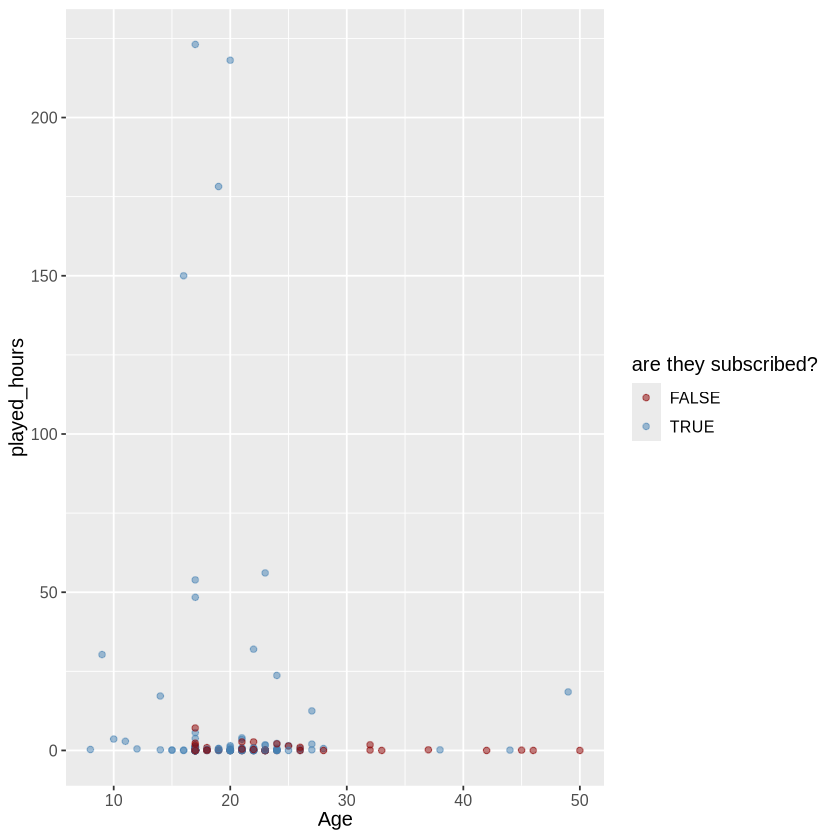

In [65]:
players_graph <- players |>
  ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
  geom_point(alpha = 0.5) +
  labs(color = "are they subscribed?") +
  scale_color_manual(values = c("darkred", "steelblue")) +
  theme(text = element_text(size = 12))

players_graph

to make it reproducable, we will create both models on the same training set and test it on the same testing set.

In [48]:
players_split <- initial_split(players, prop = 0.8, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

below are three recipes each to to test each variable alone and then one using both of them to predict it they subscribe.

In [49]:
players_1A_recipe <- recipe(subscribe ~ played_hours, data = players_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())
players_1B_recipe <- recipe(subscribe ~ Age, data = players_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())
players_2_recipe <- recipe(subscribe ~ played_hours + Age, data = players_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

now to find the best k for each we use tuning.

In [50]:
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)
players_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")
k_vals <- tibble(neighbors = 1:10)

players_1A_results <- workflow() |>
  add_recipe(players_1A_recipe) |>
  add_model(players_spec) |>
  tune_grid(resamples = players_vfold, grid = k_vals) |>
  collect_metrics()



players_1B_results <- workflow() |>
  add_recipe(players_1B_recipe) |>
  add_model(players_spec) |>
  tune_grid(resamples = players_vfold, grid = k_vals) |>
  collect_metrics()



players_2_results <- workflow() |>
  add_recipe(players_2_recipe) |>
  add_model(players_spec) |>
  tune_grid(resamples = players_vfold, grid = k_vals) |>
  collect_metrics()

players_1A_results
players_1B_results
players_2_results

→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 30 rows.
               ✖ Assigned data has 31 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 31 to size 30.

There were issues with some computations   A: x1

There were issues with some computations   A: x2



→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 30 rows.
               ✖ Assigned data has 31 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 31 to size 30.



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4233871,5,0.020161290,Preprocessor1_Model01
1,roc_auc,binary,0.5313406,5,0.024241879,Preprocessor1_Model01
2,accuracy,binary,0.4169355,5,0.018895765,Preprocessor1_Model02
2,roc_auc,binary,0.5655193,5,0.020603870,Preprocessor1_Model02
3,accuracy,binary,0.4870968,5,0.010698790,Preprocessor1_Model03
3,roc_auc,binary,0.5801932,5,0.030216869,Preprocessor1_Model03
4,accuracy,binary,0.4806452,5,0.016448450,Preprocessor1_Model04
4,roc_auc,binary,0.5699275,5,0.031177584,Preprocessor1_Model04
5,accuracy,binary,0.4741935,5,0.009677419,Preprocessor1_Model05


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4139785,3,0.04400727,Preprocessor1_Model01
1,roc_auc,binary,0.4861111,3,0.05203496,Preprocessor1_Model01
2,accuracy,binary,0.4139785,3,0.04400727,Preprocessor1_Model02
2,roc_auc,binary,0.4814815,3,0.03582931,Preprocessor1_Model02
3,accuracy,binary,0.4677419,3,0.02463750,Preprocessor1_Model03
3,roc_auc,binary,0.5060386,3,0.03380025,Preprocessor1_Model03
4,accuracy,binary,0.4358199,3,0.04072520,Preprocessor1_Model04
4,roc_auc,binary,0.4934581,3,0.03836733,Preprocessor1_Model04
5,accuracy,binary,0.4993280,3,0.04216769,Preprocessor1_Model05


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4996640,3,0.040458161,Preprocessor1_Model01
1,roc_auc,binary,0.5056361,3,0.074032218,Preprocessor1_Model01
2,accuracy,binary,0.5104167,3,0.029815164,Preprocessor1_Model02
2,roc_auc,binary,0.5511272,3,0.060242717,Preprocessor1_Model02
3,accuracy,binary,0.5537634,3,0.045935504,Preprocessor1_Model03
3,roc_auc,binary,0.5665258,3,0.070178837,Preprocessor1_Model03
4,accuracy,binary,0.5638441,3,0.027944386,Preprocessor1_Model04
4,roc_auc,binary,0.5604871,3,0.064249508,Preprocessor1_Model04
5,accuracy,binary,0.6276882,3,0.009408602,Preprocessor1_Model05


based on the tibbles we can see that for 1A we should use k = 3, for 1B we should use k = 5 and for 2 we should use k = 3.

In [51]:
players_1A_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
  set_engine("kknn") |>
  set_mode("classification")

players_1A_fit <- workflow() |>
  add_recipe(players_1A_recipe) |>
  add_model(players_1A_spec) |>
  fit(data = players_train)

players_1B_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
  set_engine("kknn") |>
  set_mode("classification")

players_1B_fit <- workflow() |>
  add_recipe(players_1B_recipe) |>
  add_model(players_1B_spec) |>
  fit(data = players_train)

players_2_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
  set_engine("kknn") |>
  set_mode("classification")

players_2_fit <- workflow() |>
  add_recipe(players_2_recipe) |>
  add_model(players_2_spec) |>
  fit(data = players_train)

now to get the metrics on our predictions

In [54]:
players_1A_predictions <- predict(players_1A_fit, players_test) |>
  bind_cols(players_test)

players_1A_test_predictions<-players_1A_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

players_1B_predictions <- predict(players_1B_fit, players_test) |>
  bind_cols(players_test)

players_1B_test_predictions<-players_1B_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

players_2_predictions <- predict(players_2_fit, players_test) |>
  bind_cols(players_test)

players_2_test_predictions<-players_2_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

players_1A_test_predictions
players_1B_test_predictions
players_2_test_predictions

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.55


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6


In [60]:
player_1A_recall <- players_1A_predictions|>
    recall(truth = subscribe, estimate = .pred_class, event_level="first")
player_1B_recall <- players_1B_predictions |>
    recall(truth = subscribe, estimate = .pred_class, event_level="first")
player_2_recall  <- players_2_predictions|>
    recall(truth = subscribe, estimate = .pred_class, event_level="first")

player_1A_recall
player_1B_recall
player_2_recall

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.7272727


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.5454545


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.4545455


there will be explanations on this in the pdf file